# "Should I stay or should I go?" is a notebook using machine learning to analyze and predict customer churn in a telecom company.
### The dataset used here is part of the [IBM Watson Analytics sample data sets](https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/)

In [2]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE

from graphviz import Source

%matplotlib inline

## Dataset information:

Demographics:
* customerID           
* gender         
* SeniorCitizen - Whether the customer is a senior citizen (1) or not (0)
* Partner - Whether the customer has a partner (1) or not (0)
* Dependents - Whether the customer has dependents (1) or not (0)
* tenure - For how many months they have been a client

Products provided by the company:
* PhoneService - Whether they have a phone service with the company
* MultipleLines - Whether they have multiple lines (yes, no, or no service)
* InternetService - Type of internet service (Fiber optic, DSL, or no service)
* OnlineSecurity - Whether the client has online security (yes, no, or no internet service)
* OnlineBackup - Whether the client has online backup (yes, no, or no internet service)
* DeviceProtection - Whether the client has device protection (yes, no, or no internet service)
* TechSupport - Whether the client has tech support (yes, no, or no internet service)
* StreamingTV - Whether the client has streaming TV (yes, no, or no internet service)
* StreamingMovies - Whether the client has streaming movies (yes, no, or no internet service)

Payment details of the customer:
* Contract - Type of contract (month-to-month, one year or two year)
* PaperlessBilling - Yes or No 
* PaymentMethod - Electronic check, Mailed check, Bank transfer (automatic), or Credit card (automatic)
* MonthlyCharges - Amount charged by the company monthly
* TotalCharges - Total amount charged by the company

Target variable:
* Churn - Whether the customer left within the last month or not
 
    
 

 
 



In [3]:
# Import dataset 
data = 'data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df_raw = pd.read_csv(data)

df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Introduction
If a company wants to keep a higher percentage of its clients, they should find out why people decide to churn.   
One way to answer this question is to find out what churning customers have in common. The present dataset might be able to help answering this question.    
Why is this useful? If we know more about the factors that add to the customer's decision to churn, the company can take measures to prevent customers from going to another provider.

Some ideas about potential factors correlating with churn that can be explored with this data set are:

- Customers with **mailed checks** are more conservative and less likely to churn.
- If you're in a **2-year contract**, you make long-term commitments and are less likely to churn.
- **Younger** customers might switch providers more often.
- Having **multiple lines** will make it harder to churn, so people think twice before churning.
- The longer you have been a customer (**tenure**), the less likely it is that you will churn. 
- High bills (**monthly and total amounts**) can be a reason for churning.
- **Multiple products** might be a reason to stay (too much trouble to switch) but also to go (if better packages are offered elsewhere). A new feature could be engineered with **"total number of products"**. 
- Customers with **paperless billing** might be more digitally up-to-date and find it easier to switch providers.


## Data cleaning and exploration

In [4]:
# Look at the shape of the data
df_raw.shape   # There are 7043 rows in the raw data (1 row for each customer)

(7043, 21)

In [5]:
# Info about number of entries and data type
df_raw.info()   # shows no missing entries, but note that object type might "hide" some missing numeric values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [6]:
# Change dataype for TotalCharges from object to numeric
df_raw['TotalCharges'] = pd.to_numeric(df_raw['TotalCharges'], errors='coerce')   
df_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# Remove rows with missing entries 
df = df_raw.dropna()
df.info()   # Note that 11 rows where dropped due to missing entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null object
dtypes: float64(2), int64(2), ob

### Looking at the summary statistics below, we can see that 26.6% of customers churned in the last month. 
This is an important number to know because it illustrates part of the company's problem (high churn rate). It also shows that we have imbalanced classes (more data for non-churning customers than for churning customers), but for this analysis that shouldn't be a big problem. (And otherwise we could randomly select non-churning customers to match the number of churning customers.) 

In [8]:
# Summary statistics
df.describe()   # note that the variables not displayed are all categorical (object type)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [9]:
# Change categorical "yes/no" into dummy variables for target "Churn" to do exploratory data analysis.
df = pd.get_dummies(df, columns=["Churn"])
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn_No,Churn_Yes
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,1,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,1,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,1,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,1


### Below are visualizations to explore the data (no statistical tests are done in this part).

In [10]:
# Group dataframe by payment method
grouped = df.groupby(["PaymentMethod"]).sum()
grouped.reset_index(level=0, inplace=True)
grouped

,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_No,Churn_Yes
0,Bank transfer (automatic),233,67406,103631.0,4748279.90,1284.0,258.0
1,Credit card (automatic),221,65856,101175.8,4671593.35,1289.0,232.0
2,Electronic check,594,59538,180345.0,4944903.25,1294.0,1071.0
3,Mailed check,94,35190,70509.2,1691392.20,1296.0,308.0


#### Payment method - The churn looks highest among the customers that pay per electronic check. Customers with mailed checks seem to churn less often, but so do customers with bank transfer and credit card as payment methods (no statistical tests done). Below is the plot showing this:

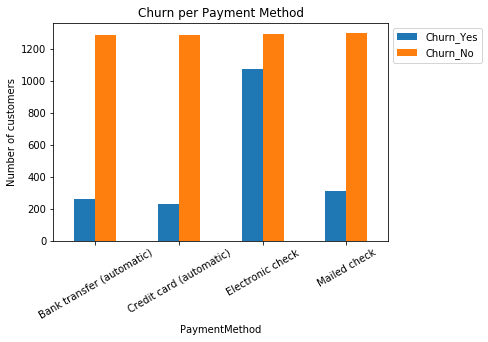

In [11]:
# Plot number of customers that stay or go per payment method.
ax = grouped.plot(x="PaymentMethod", y=["Churn_Yes", "Churn_No"], kind="bar", 
                      title='Churn per Payment Method', rot=30)
ax.set_ylabel("Number of customers")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

#### Contract type - Customer churn looks highest (relatively) in the month-to-month group (see below), even though this group also has the highest total number of customers.

In [12]:
# Group by contract type
grouped_contract = df.groupby(["Contract"]).sum()
grouped_contract.reset_index(level=0, inplace=True)

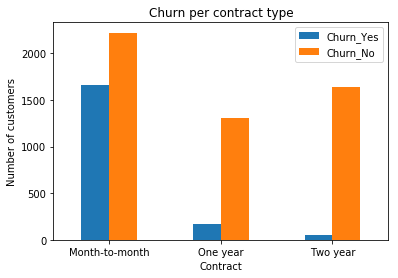

In [13]:
# Plot churn by contract type
ax = grouped_contract.plot(x="Contract", y=["Churn_Yes", "Churn_No"], kind="bar", 
                      title='Churn per contract type', rot=0)
ax.set_ylabel("Number of customers")
plt.show()

#### Age group (senior vs not senior) -  In general, more people stay than go, but total churn is higher in non-senior customers (although the number of seniors churning relative to the total number of senior customers is relatively high).

In [14]:
# Group dataframe by "SeniorCitizen"
grouped_senior = df.groupby(["SeniorCitizen"]).sum()
grouped_senior.reset_index(level=0, inplace=True)

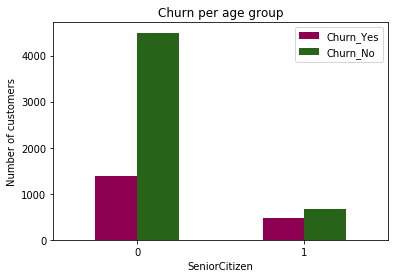

In [15]:
# Plot churn by seniority
ax = grouped_senior.plot(x="SeniorCitizen", y=["Churn_Yes", "Churn_No"], kind="bar", 
                      title='Churn per age group', colormap='PiYG', rot=0)
ax.set_ylabel("Number of customers")
plt.show()

#### Number of phone lines - Whether customers have multiple lines or not, more people stay than go, although it looks like a greater portion of people churn in the group of customers with multiple lines (again, no statistical tests done). 


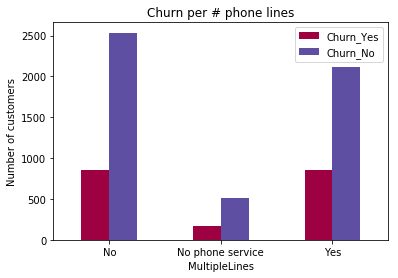

In [16]:
# Multiple lines
grouped_multilines = df.groupby(["MultipleLines"]).sum()
grouped_multilines.reset_index(level=0, inplace=True)

ax = grouped_multilines.plot(x="MultipleLines", y=["Churn_Yes", "Churn_No"], kind="bar", 
                      title='Churn per # phone lines', rot=0, colormap='Spectral')
ax.set_ylabel("Number of customers")
plt.show()

#### Tenure - As can be seen below, churning customers haven't been using the company's products for as long as non-churning customers. 
As soon as a customer leaves, the tenure measure ends. This is a consequence of leaving the company, so tenure will be **correlated** to churn, but might not be a good **predictor** for churn. 

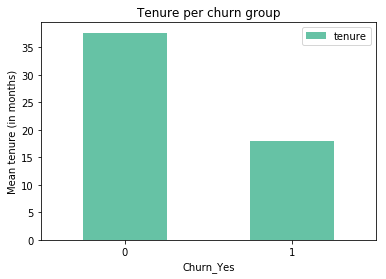

In [17]:
# Plot Tenure by churn
grouped_churn = df.groupby(["Churn_Yes"]).mean()
grouped_churn.reset_index(level=0, inplace=True)
grouped_churn
ax = grouped_churn.plot(x="Churn_Yes", y=["tenure"], kind="bar", 
                      title='Tenure per churn group', rot=0, colormap='Set2')
ax.set_ylabel("Mean tenure (in months)")
plt.show()

#### Monthly and total charges - The customers that decide to go to another provider have -on average- higher monthly bills (see plot and t-test below), but there total charges were lower. 

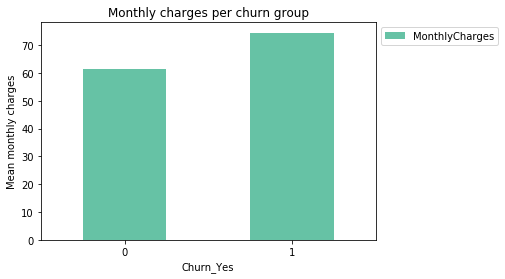

In [18]:
# Plot Monthly charges by churn
ax = grouped_churn.plot(x="Churn_Yes", y=["MonthlyCharges"], kind="bar", 
                        title='Monthly charges per churn group', rot=0, colormap='Set2')
ax.set_ylabel("Mean monthly charges")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Use a t-test to show that the difference in monthly charges for churn and no-churn groups is significant:

In [19]:
#  T-test
from scipy.stats import ttest_ind

cat1 = df[df['Churn_Yes']==1]
cat2 = df[df['Churn_Yes']==0]

ttest_ind(cat1['MonthlyCharges'], cat2['MonthlyCharges'])

Ttest_indResult(statistic=16.47959313114872, pvalue=6.760843117980302e-60)

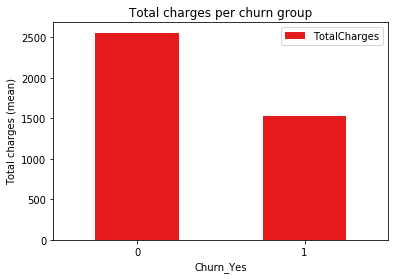

In [20]:
# Plot Total charges by churn
ax = grouped_churn.plot(x="Churn_Yes", y=["TotalCharges"], kind="bar", 
                        title='Total charges per churn group', rot=0, colormap='Set1')
ax.set_ylabel("Total charges (mean)")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

The t-test below shows that the total charges are significantly lower for customers that leave. Like tenure, this is a direct consequence of leaving the company (as soon as you leave, the charges stop), so not necessarily a useful predictor for churning. 

In [21]:
# T-test 
cat1 = df[df['Churn_Yes']==1]
cat2 = df[df['Churn_Yes']==0]

ttest_ind(cat1['TotalCharges'], cat2['TotalCharges'])

Ttest_indResult(statistic=-17.068827211220274, pvalue=4.876865689694505e-64)

#### Recoding variables and dropping columns that are redundant or not useful:

In [22]:
# Check all unique values for the categorical variables, before recoding
print(df.gender.unique())
print(df.Partner.unique())
print(df.Dependents.unique())
print(df.PhoneService.unique())
print(df.MultipleLines.unique())
print(df.InternetService.unique())
print(df.OnlineSecurity.unique())
print(df.OnlineBackup.unique())
print(df.DeviceProtection.unique())
print(df.TechSupport.unique())
print(df.StreamingTV.unique())
print(df.StreamingMovies.unique())
print(df.Contract.unique())
print(df.PaperlessBilling.unique())
print(df.PaymentMethod.unique())

['Female' 'Male']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No phone service' 'No' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [23]:
# Recoding the categorical variables with pd.get_dummies
df_dummies = pd.get_dummies(df, columns=["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", 
                            "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", 
                            "TechSupport", "StreamingTV", "StreamingMovies", 
                            "PaperlessBilling", "PaymentMethod"])

#df.head()
df_dummies.head()


,customerID,SeniorCitizen,tenure,Contract,MonthlyCharges,TotalCharges,Churn_No,Churn_Yes,gender_Female,gender_Male,...,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,1,Month-to-month,29.85,29.85,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
1,5575-GNVDE,0,34,One year,56.95,1889.50,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,2,Month-to-month,53.85,108.15,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,7795-CFOCW,0,45,One year,42.30,1840.75,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
4,9237-HQITU,0,2,Month-to-month,70.70,151.65,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0


In [24]:
# There is no information on the meaning of CustomerID (number/letter combination), so this column will be dropped. 
# Leave in only "yes columns". The "no's" are in these columns as zeros, so we don't need the separate "no"-columns.
df_clean = df_dummies.drop(['customerID','gender_Female', 'Partner_No', 'Dependents_No', 'PhoneService_No', 
                            'MultipleLines_No phone service', 'InternetService_No', 
                            'OnlineSecurity_No internet service', 'OnlineBackup_No internet service',
                            'DeviceProtection_No internet service', 'TechSupport_No internet service',
                            'StreamingTV_No internet service', 'StreamingMovies_No internet service', 
                            'PaperlessBilling_No', 'PaymentMethod_Bank transfer (automatic)', 'Churn_No', 
                            'MultipleLines_No','OnlineSecurity_No', 'OnlineBackup_No','DeviceProtection_No', 
                            'TechSupport_No', 'StreamingTV_No', 'StreamingMovies_No'], axis=1)

# Or drop less (leaves _No's in)
#df_clean = df_dummies.drop(['customerID','gender_Female', 'Partner_No', 'Dependents_No', 'PhoneService_No', 
#                            'MultipleLines_No phone service', 'InternetService_No', 
#                            'OnlineSecurity_No internet service', 'OnlineBackup_No internet service',
#                            'DeviceProtection_No internet service', 'TechSupport_No internet service',
#                            'StreamingTV_No internet service', 'StreamingMovies_No internet service', 
#                            'Contract_Month-to-month', 'PaperlessBilling_No', 
#                            'PaymentMethod_Bank transfer (automatic)', 'Churn_No'], axis=1)

#### Dependents - This factor doesn't seem to be very informative. 
Note that although numbers are higher in the upper histograms for the "no dependents" groups, the distributions of TotalCharges look similar to the lower histograms (=customers with dependents). 


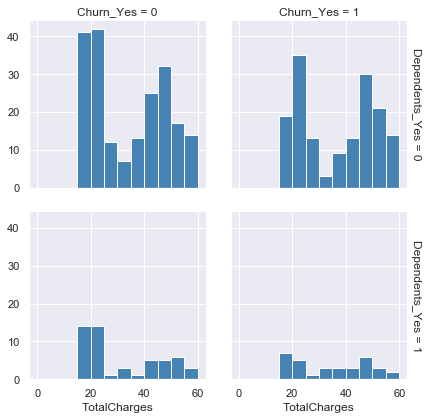

In [25]:
# Plot Total charges by churn and dependents
sns.set(style="darkgrid")

#tips = sns.load_dataset("tips")
g = sns.FacetGrid(df_clean, row="Dependents_Yes", col="Churn_Yes", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "TotalCharges", color="steelblue", bins=bins)

#### Partner & Tenure - Another look at tenure and having a partner: Most customers that churn (right columns), have shorter tenure, more so in the no partner group (< 12 months).


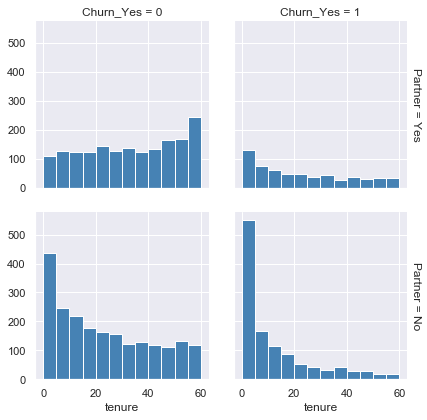

In [26]:
sns.set(style="darkgrid")

g = sns.FacetGrid(df, row='Partner', col="Churn_Yes", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "tenure", color="steelblue", bins=bins)


#### Paperless billing - Customers with paperless billing seem more likely to leave.

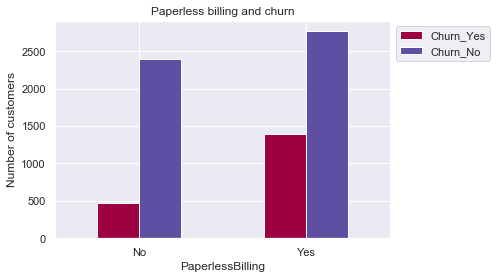

In [27]:
# Paperless billing
grouped_paperless = df.groupby(["PaperlessBilling"]).sum()
grouped_paperless.reset_index(level=0, inplace=True)
grouped_paperless

ax = grouped_paperless.plot(x="PaperlessBilling", y=["Churn_Yes", "Churn_No"], kind="bar", 
                      title='Paperless billing and churn', rot=0, colormap='Spectral')
ax.set_ylabel("Number of customers")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### Contract is an ordinal factor, so we'll convert to 1 (month-to-month), 2 (1 year contract), and 3 (2 year contract).

In [28]:
def convert_contract(x):
    if x == 'Month-to-month':
        return 1
    elif x == 'One year':
        return 2
    elif x == 'Two year':
        return 3

df_clean['Contract_ord'] = df_clean['Contract'].apply(convert_contract)

#### Tenure ranges from 1 to 72 months, so we can make a new variable with tenure_years: 0-12 months, 12-24 etc.

In [29]:
# Function to recode tenure
def tenure_cat(x):
    if 0 < x <= 12:
        return 1
    elif 12 < x <= 24:
        return 2
    elif 24 < x <= 36:
        return 3
    elif 36 < x <= 48:
        return 4
    elif 48 < x <= 60:
        return 5
    elif 60 < x <= 72:
        return 6

# Apply recoding function to data
df_clean['tenure_years'] = df_clean['tenure'].apply(tenure_cat)
df_dummies['tenure_years'] = df_dummies['tenure'].apply(tenure_cat)

In [30]:
# Drop original tenure and contract column
df_clean = df_clean.drop(['tenure', 'Contract'], axis=1)

In [31]:
# Grouping dataframe by tenure (in years) shows that most churn occurs in the first year
grouped_tenureyears = df_dummies.groupby(["tenure_years"]).sum()
grouped_tenureyears.reset_index(level=0, inplace=True)
grouped_tenureyears.head()

,tenure_years,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_No,Churn_Yes,gender_Female,gender_Male,Partner_No,...,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,320,10343,122174.15,601651.90,1138.0,1037.0,1079.0,1096.0,1621.0,...,487.0,1174.0,507.0,494.0,892.0,1283.0,227.0,224.0,978.0,746.0
1,2,168,18792,62829.85,1153287.70,730.0,294.0,508.0,516.0,590.0,...,333.0,453.0,239.0,332.0,413.0,611.0,177.0,181.0,380.0,286.0
2,3,158,25242,54558.80,1655845.80,652.0,180.0,405.0,427.0,427.0,...,322.0,332.0,170.0,330.0,345.0,487.0,182.0,188.0,284.0,178.0
3,4,123,32447,50534.50,2154534.55,617.0,145.0,400.0,362.0,356.0,...,332.0,270.0,167.0,325.0,312.0,450.0,194.0,191.0,236.0,141.0
4,5,147,45335,58698.25,3201646.30,712.0,120.0,417.0,415.0,311.0,...,417.0,252.0,161.0,419.0,327.0,505.0,239.0,225.0,247.0,121.0


#### Tenure - Another look at tenure from a different angle. The chances of churning in the first year are almost 50/50. With longer tenure, the number of "not churning" customers goes up, and churning customers goes down. 

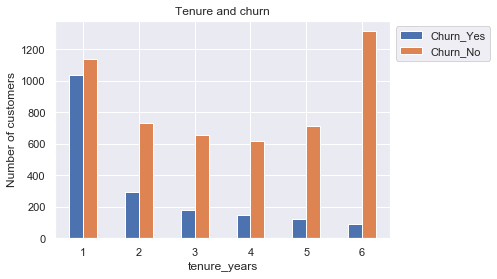

In [32]:
# Tenure in years and churn
ax = grouped_tenureyears.plot(x="tenure_years", y=["Churn_Yes", "Churn_No"], kind="bar", 
                      title='Tenure and churn', rot=0)
ax.set_ylabel("Number of customers")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### A new feature "total number of products" is created as a result of the *hypothesis* that having more products could be related to a lower chance of leaving. 

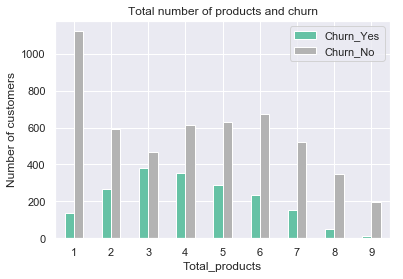

In [33]:
# Make a new feature (column) with the total number of products for each customer. 

def calc_totalprod(row):
    sumprod = row['PhoneService_Yes'] + row['MultipleLines_Yes'] + row['InternetService_DSL'] + row['InternetService_Fiber optic'] + row['OnlineSecurity_Yes'] + row['OnlineBackup_Yes'] + row['DeviceProtection_Yes'] + row['TechSupport_Yes'] + row['StreamingTV_Yes'] + row['StreamingMovies_Yes']
    return sumprod

df_clean['Total_products'] = df_clean.apply (lambda row: calc_totalprod (row),axis=1)   # only if we decide to use this new feature
df_dummies['Total_products'] = df_dummies.apply (lambda row: calc_totalprod (row),axis=1)   # for exploration


# Group by new variable total products
grouped_totalprod = df_dummies.groupby(['Total_products']).sum()
grouped_totalprod.reset_index(level=0, inplace=True)

# Plot by churn
ax = grouped_totalprod.plot(x='Total_products', y=["Churn_Yes", "Churn_No"], kind="bar", 
                      title='Total number of products and churn', rot=0, colormap='Set2')
ax.set_ylabel("Number of customers")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### Heatmap
In the heatmap with correlations below, we can see that some factors are positively correlated with churn (e.g. "InternetService_Fiber optic" and "PaymentMethod_Electronic check") whereas others are negatively correlated (e.g. type of contract and tenure in years). 

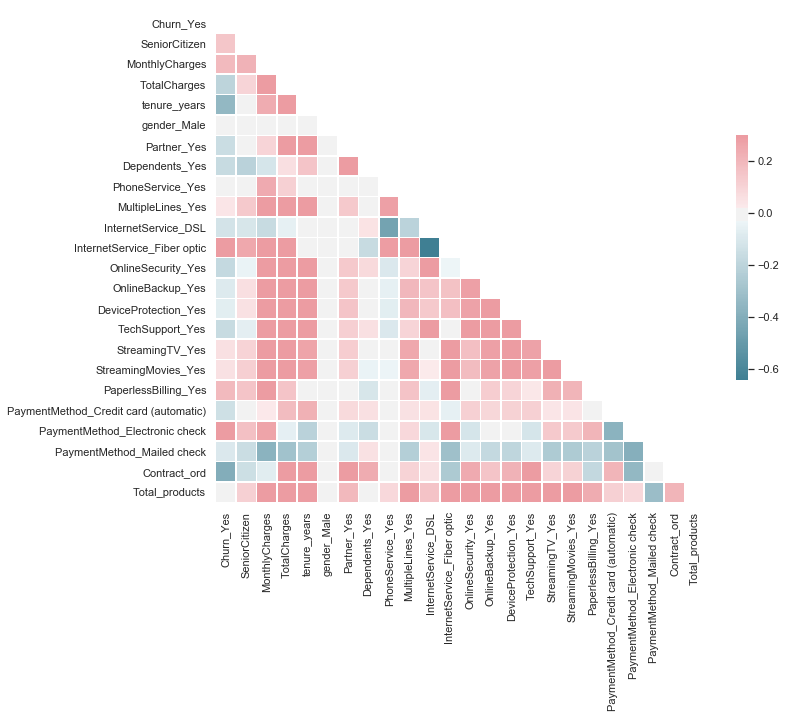

In [34]:
# Make a correlation heatmap with all the factors that will be used as features for ML.
# Code from Seaborn's examples: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Reorder the columns to make the correlation search easier (visually).
df_vis = df_clean[['Churn_Yes', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges', 'tenure_years',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes', 
       'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes','OnlineBackup_Yes', 
       'DeviceProtection_Yes',u'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 
       'PaperlessBilling_Yes','PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 
       'PaymentMethod_Mailed check', 'Contract_ord', 'Total_products']]

sns.set(style="white")
corr = df_vis.corr()

# Generate a mask the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Extra: Show how monthly and total charges are related.

#sns.set(style="darkgrid")
#g = sns.jointplot("MonthlyCharges", "TotalCharges", data=df, kind="reg",
#                  color="m", height=7)

## Model 1) Logistic regression
The first model fit to the data is a logistic regression model, that makes a binary classification and predicts whether a customer churns or not, based on the values of their features. In this example, all the remaining 23 features (after data cleaning) are used because they might be meaningful. 


In [35]:
# The data -with Churn_Yes as target- now looks like this:
#df_clean.head()   # to see the first five rows of the dataframe
df_clean.shape   # numbers of rows (customers) and number of features+1 (the +1 for the target)

(7032, 24)

In [36]:
# Define features and target 
X_unscaled = df_clean.drop('Churn_Yes', axis=1).values   # every column except Churn
X = scale(X_unscaled)

# Print out to check what scaling did.
print("Mean of Unscaled Features: {}".format(np.mean(X_unscaled))) 
print("Std of Unscaled Features: {}".format(np.std(X_unscaled)))
print("Mean of Scaled Features: {}".format(np.mean(X))) 
print("Std of Scaled Features: {}".format(np.std(X)))

y = df_clean['Churn_Yes'].values   # target:  churn (1) or not (0)?   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
print("Size of predictors in training set: " + str(X_train.size))

Mean of Unscaled Features: 102.786267127
Std of Unscaled Features: 663.100031314
Mean of Scaled Features: 9.09397699352e-18
Std of Scaled Features: 1.0
Size of predictors in training set: 97037


### Classification measures 
* The accuracy of the model is ~79% Accuracy can be misleading however, especially in unbalanced models. 
* Precision  is the positive predictive value, or proportion of correctly identified churning customers out of all customers predicted to churn. 
* Recall is a measure of sensitivity, or proportion of correctly identified churning customers against all "real" churning customers.
* F-1 score weights both recall and precision, and gives an idea of how good the model is.  

In [37]:
# Logistic regression model 1
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

predictions = [round(value) for value in y_pred]

# Evaluate predictions 
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0) +  '\n')
print("confusion_matrix: " +  '\n' + str(confusion_matrix(y_test, y_pred)) +  '\n')
print("classification report: " +  '\n' + str(classification_report(y_test, y_pred)) +  '\n')

Accuracy: 78.88%

confusion_matrix: 
[[1807  258]
 [ 336  412]]

classification report: 
             precision    recall  f1-score   support

          0       0.84      0.88      0.86      2065
          1       0.61      0.55      0.58       748

avg / total       0.78      0.79      0.78      2813




### ROC curve and AUC
As an indicator of usefullness of our model, we can use the area under the curve (AUC). 
The Area Under the ROC curve of .84 for this logistic regression model is good, but not excellent. 

In [38]:
# Calculate AUROC score
y_pred_prob = logreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.8352976783933913

A model that performs well gives an ROC curve with a large area under the curve (AUC), i.e. that is very close to the top left of the plot. 
An ROC (Receiver Operating Characteristic) is a measure of the accuracy of a model but for different classification thresholds. As can be seen in the plot below, the present model is not very good, but does give some info about customers (the dashed line would be found when the model made random guesses, our line is somewhere in between a great model and a random model).

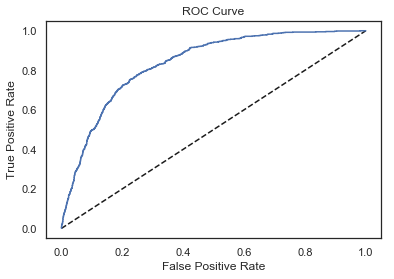

In [39]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Using cross-validation avoids overfitting:  

In [40]:
# Compute AUROC using cross-validation (to avoid overfitting)
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print("Average 10-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 10-Fold CV Score: 0.839648035291


### Feature importance
To see which features are most important for the model (=most predictive in deciding whether a customer will or will not churn) we can print the logreg coefficients.

Internet Service (Fiber optic, DSL), Tenure and Contract and also Total Products and Monthly charges appear to be the most important factors (but remember that tenure length is also a **result** of churning)


In [41]:
# Get feature names
df_featurenames = df_clean.drop('Churn_Yes', axis=1)
featnames = list(df_featurenames)
#coef_list = list(logreg.coef_)   # np.array to list
coefs = logreg.coef_

from itertools import chain
coef_list = list(chain.from_iterable(coefs))

# Print feature names and importance in the model (note that there are negative factors too!)
zipped_logreg = zip(featnames, coef_list)
for name, importance in sorted(zipped_logreg, key=lambda x: x[1], reverse=True):
    print(name, importance)

('InternetService_Fiber optic', 1.0723630913217388)
('InternetService_DSL', 0.49035017510067375)
('Total_products', 0.2746382542659338)
('PaymentMethod_Electronic check', 0.1883666853785999)
('PaperlessBilling_Yes', 0.15732550809881737)
('StreamingTV_Yes', 0.14525498524457595)
('StreamingMovies_Yes', 0.11679651425865197)
('PaymentMethod_Mailed check', 0.0888216261570758)
('MultipleLines_Yes', 0.08029920748818664)
('SeniorCitizen', 0.0642864450463526)
('TotalCharges', 0.01438664579443474)
('PaymentMethod_Credit card (automatic)', 0.010700781681879745)
('gender_Male', -0.0018182084889468797)
('Partner_Yes', -0.004692092381817731)
('DeviceProtection_Yes', -0.013383482941752995)
('PhoneService_Yes', -0.10592172078826968)
('Dependents_Yes', -0.11682330111350032)
('OnlineBackup_Yes', -0.12494258904675289)
('OnlineSecurity_Yes', -0.2104825687929355)
('TechSupport_Yes', -0.23188582420914397)
('MonthlyCharges', -0.2850422495046972)
('Contract_ord', -0.6336880862268063)
('tenure_years', -0.68361

### GridSearchCV
Use a combination of cross-validation and GridSearchCV (=selecting the values for a model’s parameters that maximize accuracy of that model). Regularization adds a penalty term to the loss function to avoid overfitting. 

In [43]:
# GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)   # hyperparameter space
penalty = ['l1', 'l2']   # Create regularization penalty space: lasso (L1) and ridge (L2)
param_grid = {'C': c_space, 'penalty': penalty}   

logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X,y)

# Print the best score and tuned parameters
print("Best score is {}".format(logreg_cv.best_score_))
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 


Best score is 0.798919226394
Tuned Logistic Regression Parameters: {'penalty': 'l2', 'C': 268.2695795279727}


A new classifier can be trained using the best parameters that were found by the grid search above.
Run the code below to see that, for this sample dataset, results stay more or less the same.


In [44]:
# Logistic regression model 1 - with best params
logreg2 = LogisticRegression(C=0.0517947467923, penalty='l2')
logreg2.fit(X_train,y_train)
y_pred = logreg2.predict(X_test)

predictions = [round(value) for value in y_pred]

# Evaluate predictions 
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0) +  '\n')
print("confusion_matrix: " +  '\n' + str(confusion_matrix(y_test, y_pred)) +  '\n')
print("classification report: " +  '\n' + str(classification_report(y_test, y_pred)) +  '\n')


Accuracy: 79.10%

confusion_matrix: 
[[1808  257]
 [ 331  417]]

classification report: 
             precision    recall  f1-score   support

          0       0.85      0.88      0.86      2065
          1       0.62      0.56      0.59       748

avg / total       0.79      0.79      0.79      2813




## Model 2) Logistic regression with recursive feature selection

Recursive feature elimination (RFE) can be used to select the most important features in the dataset. 

In [46]:
# Recursive feature elimination
logreg = LogisticRegression()
rfe = RFE(logreg, 18)
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True False False False  True  True  True  True  True  True  True
  True  True  True  True  True False  True False  True  True  True]
[1 1 3 6 4 1 1 1 1 1 1 1 1 1 1 1 1 2 1 5 1 1 1]


In [70]:
# RFE suggests to keep these columns:
cols = ['SeniorCitizen', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes', 
        'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes',
        'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 
        'StreamingMovies_Yes', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 'Contract_ord', 'tenure_years', 'Total_products']

# And to drop these columns:
drop_cols = ['MonthlyCharges', 'TotalCharges', 'gender_Male','Partner_Yes', 'PaymentMethod_Mailed check']

### Define the train and test data and fit the model

In [48]:
# Define features and target 
X_unscaled = df_clean[cols].values   # every column except Churn
X = X_unscaled   # no scaling neede in this example

y = df_clean['Churn_Yes'].values   # target:  churn (1) or not (0)?   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
print("Size of predictors in reduced training set: " + str(X_train.size))

Size of predictors in reduced training set: 75942


In [49]:
# Logistic regression model -  reduced features
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

predictions = [round(value) for value in y_pred]

# Evaluate predictions 
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0) +  '\n')
print("confusion_matrix: " +  '\n' + str(confusion_matrix(y_test, y_pred)) +  '\n')
print("classification report: " +  '\n' + str(classification_report(y_test, y_pred)) +  '\n')

Accuracy: 78.95%

confusion_matrix: 
[[1805  260]
 [ 332  416]]

classification report: 
             precision    recall  f1-score   support

          0       0.84      0.87      0.86      2065
          1       0.62      0.56      0.58       748

avg / total       0.78      0.79      0.79      2813




### ROC and AUC

In [50]:
# Calculate AUC score
y_pred_prob = logreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.8360532040242907

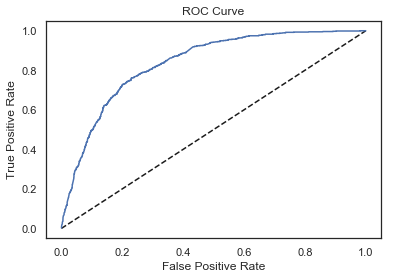

In [51]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [52]:
# Compute AUC using cross-validation (to avoid overfitting)
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print("Average 10-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 10-Fold CV Score: 0.840179631795


### Feature importance

In [71]:
#### Contract, Internet Service, Tenure, and Total Charges are the most important factors.
# Internet Service (Fiber optic, DSL), Tenure and Contract and also Total Products and Monthly charges appear to be the most important factors. 

df_featurenames = cols
featnames = list(df_featurenames)
#coef_list = list(logreg.coef_)   # np.array to list
coefs = logreg.coef_

from itertools import chain
coef_list = list(chain.from_iterable(coefs))

# Print feature names and importance in the model (note that there are negative factors too!)
zipped_logreg = zip(featnames, coef_list)
for name, importance in sorted(zipped_logreg, key=lambda x: x[1], reverse=True):
    print(name, importance)

('InternetService_Fiber optic', 1.542007046163829)
('InternetService_DSL', 0.6627142340229109)
('PaperlessBilling_Yes', 0.31816026492432914)
('PaymentMethod_Electronic check', 0.29712517811975975)
('Total_products', 0.18482955203443788)
('SeniorCitizen', 0.17368214546318186)
('StreamingTV_Yes', 0.13940431694397815)
('StreamingMovies_Yes', 0.08066218758145008)
('MultipleLines_Yes', 0.04853183479064643)
('PaymentMethod_Credit card (automatic)', -0.07518136895859252)
('DeviceProtection_Yes', -0.13650867040018286)
('Dependents_Yes', -0.2614567447800692)
('tenure_years', -0.3584108583313011)
('OnlineBackup_Yes', -0.36778037305083633)
('OnlineSecurity_Yes', -0.5674294444928669)
('PhoneService_Yes', -0.606127686693454)
('TechSupport_Yes', -0.610643892832604)
('Contract_ord', -0.7685355374597076)


## Model 3) Decision Tree
The second type of model fit to the data is a decision tree model, which makes multiple splits to predict whether a customer will churn or not, based on the values of their features.

Split the data into train and test data, select the model, and train the classifier:

In [61]:
# Define features and target. This time all features will be included again. 
X_df_all = df_clean.drop('Churn_Yes', axis=1)
X_unscaled = X_df_all.values   # every column except "Churn_Yes"
#X_unscaled = df_clean[['SeniorCitizen','MonthlyCharges', 'Contract_One year', 'Contract_Two year']].values
X = X_unscaled
#X = scale(X_unscaled)   # choose this if you want to normalize the features, but in this case that gives the same result as without scaling. 

y = df_clean['Churn_Yes'].values   # target:  churn (1) or not (0)?   

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [62]:
# Select and train the classifier
classifier = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)  
classifier.fit(X_train, y_train) 

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

### The Decision Tree classifier results:

The decision tree results are quite similar to the results of the regression model:
* Accuracy: 78.3%
* Precision avg: .77
* Recall avg: .78


In [63]:
# Make predictions
y_pred = classifier.predict(X_test) 

predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0) +  '\n')
print("confusion_matrix: " +  '\n' + str(confusion_matrix(y_test, y_pred)) +  '\n')
print("classification report: " +  '\n' + str(classification_report(y_test, y_pred)) +  '\n')

Accuracy: 78.28%

confusion_matrix: 
[[1938  127]
 [ 484  264]]

classification report: 
             precision    recall  f1-score   support

          0       0.80      0.94      0.86      2065
          1       0.68      0.35      0.46       748

avg / total       0.77      0.78      0.76      2813




### The decision tree below displays the result of the classification, and has valuable information:
* The first **split** is made on contract type. Remember that this was coded as 1 (month-to-month), 2 (1 year) or 3 (2 year) in our features. If a customer's contract is <= 1.5, which means a month-to-month contract, the customer sample goes to the left, and if they have a longer term contract (1 or 2 year contract) their sample goes to the right. 
* Note that a low **Gini index** (gini impurity) is desired (a perfect classification would give a Gini Index of zero, and a evenly distributed classification would be 1 – (1/number of classes).
* Under the gini index, the number of **samples** (=observations remaining) is given that the split will be made on. 
* The **value** indicates how many customers are in class 0 (No Churn) and how many samples are in class 1 (Churn).
* Note that **max_depth** was set to 3, so the tree stops after three split levels in this example. 

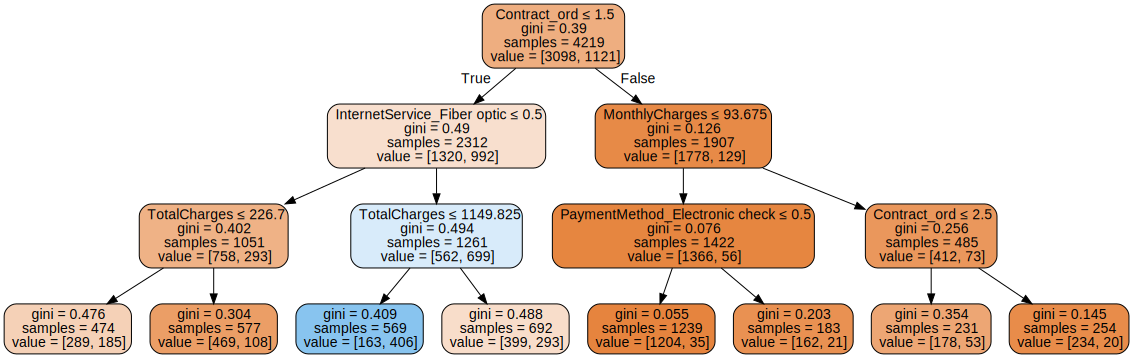

In [69]:
# Plot the decision tree
from IPython.display import SVG

graph = Source(tree.export_graphviz(classifier, out_file=f,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_df_all.columns))
SVG(graph.pipe(format='svg'))

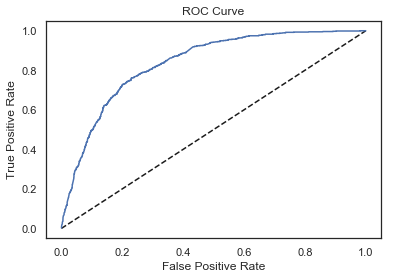

In [65]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [66]:
# Save tree image info to file
with open("classifier_model3.txt", "w") as f:
    #f = tree.export_graphviz(classifier, out_file=f)
    f = tree.export_graphviz(classifier, out_file=f,  
                filled=True, rounded=True,
                special_characters=True)

### Cross-validation and AUC

In [67]:
# Compute AUC using cross-validation (to avoid overfitting)
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')
print("Average 10-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 10-Fold CV Score: 0.839190338354


### Feature importance

In [68]:
### from IBM: Contract, Internet Service, Tenure, and Total Charges are the most important factors.
# from model 3: Contract and Internet service, Total charges, Monthly Charges,  
# from model 1: Internet Service (Fiber optic, DSL), Tenure, Contract and Monthly charges

zipped = zip(X_df_all.columns, classifier.feature_importances_)
for name, importance in sorted(zipped, key=lambda x: x[1], reverse=True):
    print(name, importance)

('Contract_ord', 0.6176613152407221)
('InternetService_Fiber optic', 0.19303739874316167)
('TotalCharges', 0.16419682382750397)
('MonthlyCharges', 0.01981205824965655)
('PaymentMethod_Electronic check', 0.00529240393895571)
('SeniorCitizen', 0.0)
('gender_Male', 0.0)
('Partner_Yes', 0.0)
('Dependents_Yes', 0.0)
('PhoneService_Yes', 0.0)
('MultipleLines_Yes', 0.0)
('InternetService_DSL', 0.0)
('OnlineSecurity_Yes', 0.0)
('OnlineBackup_Yes', 0.0)
('DeviceProtection_Yes', 0.0)
('TechSupport_Yes', 0.0)
('StreamingTV_Yes', 0.0)
('StreamingMovies_Yes', 0.0)
('PaperlessBilling_Yes', 0.0)
('PaymentMethod_Credit card (automatic)', 0.0)
('PaymentMethod_Mailed check', 0.0)
('tenure_years', 0.0)
('Total_products', 0.0)


## Conclusion

Two types of models, logistic regression and decision tree, were used to find which features can predict customer churn best in a sample dataset from a telecom company. 

A summary of the classification results:

Regression models:  
Model 1 (all features): 79% accuracy, 0.78 for precision, 0.79 for recall, 0.79 for f-1 score  
Model 2 (selected features): 79% accuracy, 0.78 for precision, 0.79 for recall, 0.79 for f-1 score
    
Decision tree model:  
Model3 (all features): 78% accuracy, 0.77 for precision, 0.78  for recall, 0.76 for f-1 score

And a summary of importances of features according to these models:  
Model 1: Internet Service (Fiber optic, DSL), Tenure, Contract, Monthly charges and Total Products.
Model 2: Internet Service (Fiber optic, DSL), Contract, Tech support, Phone service, OnlineSecurity, Online Backup and tenure (in years). 
Model 3: Contract and Internet service, Total charges, Monthly Charges, PaymentMethod (Electronic check).

The models were able to make a reasonably good (but not exellent) prediction about which customers were likely to churn.    
Although the accuracy of the models (and precision and recall) were more or less similar for the 3 models, note that the features that were marked as important do differ somewhat. However, all models suggest that **Contract Type** and **Internet Service** are good predictors of churning, and two models indicate that **Monthly Charges** should be taken into account.

**Tenure** and **Total Charges** were found to be important features too, but although membership length and how much someone has paid in total could be considered by a customer when deciding to stay or go, the values of these factors are also directly influenced by the decision to go, so the question is how useful these two measures are for **prediction** in a new dataset with only customers that haven't churned yet. 

### Extra 
Hypotheses explored by EDA plots (but most not answered by t-tests/ANOVA, because that was not the goal of the present study):

Idea: Customers with mailed checks are more conservative and less likely to churn.  
Answer: Mailed check, credit card and bank transfer users are all less likely to churn than electronic check users. 

Idea: If you're in a 2-year contract, you make long-term commitments and are less likely to churn.  
Answer: This is true for 1 *and* 2 year contracts; month-to-month group has the most churning customers. 

Idea: Younger customers might switch providers more often.  
Answer: Relative to total group sizes for senior and non-senior, seniors churn more often. The non-senior group is much bigger though, so the company might want to focus on retaining those customers more. 

Idea: Having multiple lines will make it harder to churn, so people think twice before churning.  
Answer: Number of lines doesn’t seem to make a big difference in the customer’s “stay or go decision”

Idea: The longer you have been a customer (tenure), the less likely it is that you will churn.  
Answer: True, but per definition, tenure ends when the customer leaves, so this is also a consequence of churning, not necessarily a cause (as the hypothesis would suggest).

Idea: High bills (monthly and total amounts) can be a reason for churning.  
Answer: Customers with high monthly bills are more likely to leave. Total amount is related to churn, but probably not a good predictor, for the same reason as tenure is probably not a good predictor (see previous hypothesis).

Idea: Multiple products might be a reason to stay (too much trouble to switch) but also to go (if better packages are offered elsewhere). A new feature could be engineered with "total number of products".  
Answer: Relatively most customers churn when they have 3 or 4 products, not  when they have very little (1) or many (up to 9) products. Note that there is some overlap in products (if you stream movies, you have internet too), so this measure could be improved.

Idea: Customers with paperless billing might be more digitally up-to-date and find it easier to switch providers.  
Answer: Customers with paperless billing are indeed more likely to leave (for what reason we can only guess). 
